# Inference ensemble

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

# Silence tensorflow, except for errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Run on the GTX1080 GPU - fastest single worker/small memory performance
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_project_root()

# Standard library imports
import pickle
import random
from functools import partial
from pathlib import Path

# Third party imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.interpolate import griddata

# Local imports
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/model_training'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

sample_size = 883  # Number of time points per sample
samples = 10       # Number of samples to draw per planet
planets = 50       # Number of planets to evaluate

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Load trained model

In [2]:
model_save_file = f'{config.MODELS_DIRECTORY}/optimized_cnn-13ksteps.keras'
model = tf.keras.models.load_model(model_save_file)

# You can then use the loaded model for prediction or other operations
# For example, to print a summary of the model's architecture:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 883, 283, 88)      440       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 441, 141, 88)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 441, 141, 52)      73268     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 220, 70, 52)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 70, 31)       14539     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 35, 31)     

## 2. Data preparation

### 2.1. Training/validation split

In [3]:
planet_ids_file = f'{config.METADATA_DIRECTORY}/planet_ids.pkl'

if Path(planet_ids_file).exists():

    with open(planet_ids_file, 'rb') as input_file:
        planet_ids = pickle.load(input_file)
        training_planet_ids = planet_ids['training']
        validation_planet_ids = planet_ids['validation']

    print('Loaded existing training/validation split')

Loaded existing training/validation split


### 2.2. Prediction dataset

In [4]:
def prediction_data_loader(planet_ids: list, data_file: str, sample_size: int = 100, n_samples: int = 10):
    '''Generator that yields signal, spectrum pairs for training/validation/testing.

    Args:
        planet_ids (list): List of planet IDs to include in the generator.
        data_file (str): Path to the HDF5 file containing the data.
        sample_size (int, optional): Number of frames to draw from each planet. Defaults to 100.
    '''

    with h5py.File(data_file, 'r') as hdf:

        while True:
            
            for planet_id in planet_ids:

                signal = hdf[planet_id]['signal'][:]

                samples = []
                spectra = []

                for _ in range(n_samples):

                    indices = random.sample(range(signal.shape[0]), sample_size)
                    samples.append(signal[sorted(indices), :])
                    spectra.append(hdf[planet_id]['spectrum'][:])

                yield np.array(samples), np.array(spectra)


In [5]:
prediction_data_generator = partial(
    prediction_data_loader,
    planet_ids=validation_planet_ids,
    data_file=f'{config.PROCESSED_DATA_DIRECTORY}/train.h5',
    sample_size=sample_size,
    n_samples=samples
)

In [6]:
prediction_dataset = tf.data.Dataset.from_generator(
    prediction_data_generator,
    output_signature=(
        tf.TensorSpec(shape=(samples, sample_size, config.WAVELENGTHS), dtype=tf.float64),
        tf.TensorSpec(shape=(samples, config.WAVELENGTHS), dtype=tf.float64)
    )
)

In [7]:
validation_data = prediction_dataset.take(planets)

signals = np.array([element[0].numpy() for element in validation_data])
spectra = np.array([element[1].numpy() for element in validation_data])

print(f'Signals shape: {signals.shape}')
print(f'Spectra shape: {spectra.shape}')

Signals shape: (50, 10, 883, 283)
Spectra shape: (50, 10, 283)


## 3. Predictions

In [8]:
spectrum_predictions = []

for planet in signals:
    spectrum_predictions.append(model.predict(planet, batch_size=samples, verbose=0))

spectrum_predictions = np.array(spectrum_predictions)
spectrum_predictions_avg = np.mean(spectrum_predictions, axis=1).flatten()
spectrum_predictions_std = np.std(spectrum_predictions, axis=1).flatten()
spectrum_predictions = spectrum_predictions.flatten()
reference_spectra = spectra[:,0,:].flatten()
spectra = spectra.flatten()

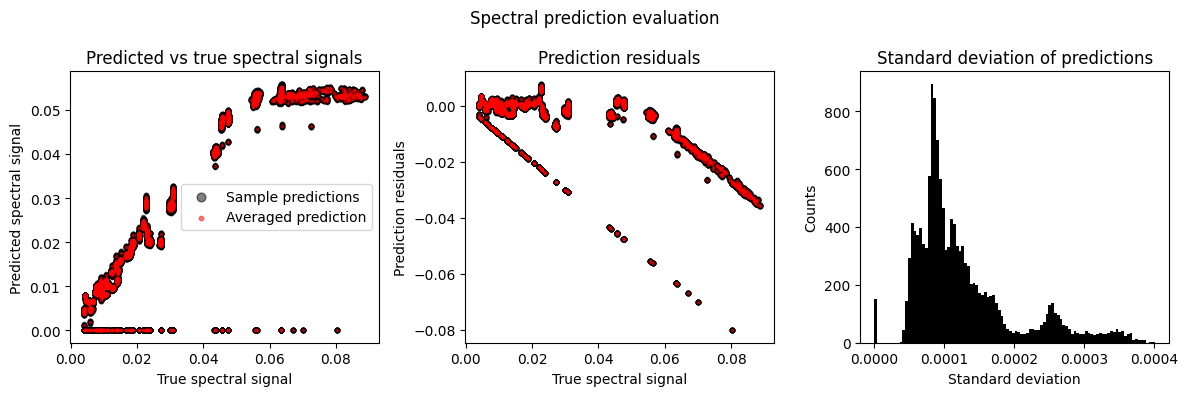

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

fig.suptitle('Spectral prediction evaluation')

axs[0].set_title('Predicted vs true spectral signals')
axs[0].scatter(spectra, spectrum_predictions, s=10, alpha=0.5, color='black', label='Sample predictions')
axs[0].scatter(reference_spectra, spectrum_predictions_avg, s=2.5, alpha=0.5, color='red', label='Averaged prediction')
axs[0].set_xlabel('True spectral signal')
axs[0].set_ylabel('Predicted spectral signal')
axs[0].legend(loc='best', markerscale=2)

residuals = spectrum_predictions - spectra
avg_residual = spectrum_predictions_avg - reference_spectra

axs[1].set_title('Prediction residuals')
axs[1].scatter(spectra, residuals, s=10, alpha=0.5, color='black', label='Sample predictions')
axs[1].scatter(reference_spectra, avg_residual, s=2.5, alpha=0.5, color='red', label='Averaged prediction')
axs[1].set_xlabel('True spectral signal')
axs[1].set_ylabel('Prediction residuals')

axs[2].set_title('Standard deviation of predictions')
axs[2].hist(spectrum_predictions_std, bins=100, color='black')
axs[2].set_xlabel('Standard deviation')
axs[2].set_ylabel('Counts')

fig.tight_layout()
plt.savefig(
    f'{figures_dir}/03.3.1-prediction_evaluation.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

plt.show()